0.5431034482758621
0.6987951807228916
0.5689655172413793
1.0
0.5905172413793104
1.0
Random Forest: 0.6563088512241054
1. feature 6 (0.221321)
2. feature 7 (0.214495)
3. feature 5 (0.183521)
4. feature 2 (0.116995)
5. feature 3 (0.106931)
6. feature 4 (0.089694)
7. feature 0 (0.039898)
8. feature 1 (0.027145)


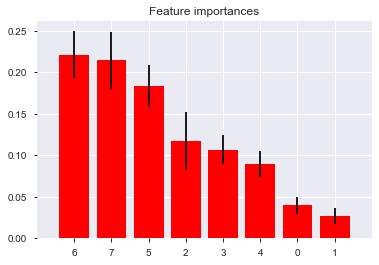

In [22]:
#%%
# read packages
import random
import numpy as np
import pandas as pd
import pandas_profiling
 
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
 
 
# set out seed 
np.random.seed(619)
#%%
# import OK cupid data
ok = pd.read_csv('https://www.dropbox.com/s/db8t2ywm4xmy4t6/okcupid.csv?dl=1')
 
#%%
# check the data format
# politics (target)
le_politics = preprocessing.LabelEncoder().fit(ok['q212813'].unique())
ok.loc[:,'politics'] = le_politics.transform(ok['q212813'])
# le_politics.inverse_transform([0,1,2])
 
# gender
le_gender = preprocessing.LabelEncoder().fit(ok['gender'].unique())
ok.loc[:,'gender'] = le_gender.transform(ok['gender'])
 
# income
le_income = preprocessing.LabelEncoder().fit(ok['d_income'].unique())
ok.loc[:,'income'] = le_income.transform(ok['d_income'])
 
# bodytype
le_bodytype = preprocessing.LabelEncoder().fit(ok['d_bodytype'].unique())
ok.loc[:,'bodytype'] = le_bodytype.transform(ok['d_bodytype'])
 
# race
le_race = preprocessing.LabelEncoder().fit(ok['race'].unique())
ok.loc[:,'race'] = le_race.transform(ok['race'])
 
# religion
le_religion = preprocessing.LabelEncoder().fit(ok['d_religion_type'].unique())
ok.loc[:,'religion'] = le_religion.transform(ok['d_religion_type'])
 
# hold out random portion for test
msk = np.random.rand(len(ok)) < 0.8
train = ok[msk]
test = ok[~msk]
 
#%%
# take a look at the data
profile = train.profile_report()
profile.to_file(output_file='report.html')
 
#%%
# sample tree
X = train.loc[:, ['income']]
X = X.to_numpy().reshape(-1,1) # if only 1
Y = train['politics']
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

# check out accuracy 
test_X = test.loc[:, ['income']]
test_X = test_X.to_numpy().reshape(-1,1)
 
pred = clf.predict(test_X)
print(accuracy_score(test['politics'], pred))
 
 
#%%
# bigger tree
feats = ['race', 'religion', 'income'] 
X = train.loc[:, feats]
Y = train['politics']
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
# check out accuracy 
# in sample:
pred = clf.predict(train.loc[:, feats])
print(accuracy_score(train['politics'], pred))
# out sample:
pred = clf.predict(test.loc[:, feats])
print(accuracy_score(test['politics'], pred))
 
#%%
# Everything
all_feat = ['race'
            , 'gender'
            , 'religion'
            , 'income'
            , 'bodytype'
            , 'p_kinky'
            , 'p_artsy'
            , 'p_scien']
 
X = train.loc[:, all_feat]
Y = train['politics']
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

# check out accuracy 
# in sample:
pred = clf.predict(train.loc[:, all_feat])
print(accuracy_score(train['politics'], pred))
# out sample:
pred = clf.predict(test.loc[:, all_feat])
print(accuracy_score(test['politics'], pred))
 
 
#%%
# Bagging
X = ok.loc[:, all_feat]
Y = ok['politics']
bag = BaggingClassifier(n_estimators=1000, oob_score=True)
bag = bag.fit(X, Y)
# check out accuracy 
# in sample:
pred = bag.predict(ok.loc[:, all_feat])
print(accuracy_score(ok['politics'], pred))
# out sample:
bag.oob_score_
 
#%%
# Random Forest
X = ok.loc[:, all_feat]
Y = ok['politics']
rf = RandomForestClassifier(n_estimators=10000, oob_score=True)
rf = rf.fit(X, Y)
# check out accuracy 
print("Random Forest: " + str(rf.oob_score_))
 
#%%
# what features were important?
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
 
# Print the feature ranking
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
 
# graph it 
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
 
#%%
# Merging
 
# chop up the data first
# assign user ID
ok.loc[:, 'user_id'] = np.random.choice(range(1000, 10000), len(ok), replace=False)
 
# create copies with only certain columns
ok1 = ok.loc[:, ['user_id', 'age', 'religion', 'income']]
ok2 = ok.loc[:, ['user_id', 'race', 'politics', 'p_kinky']]
 
# delete randomly from each
n_remove = 200
 
drop_indices = np.random.choice(ok1.index, n_remove, replace=False)
ok1 = ok1.drop(drop_indices)
 
drop_indices = np.random.choice(ok2.index, n_remove, replace=False)
ok2 = ok2.drop(drop_indices)
 
# left merge 
left = ok1.merge(ok2, how = 'left', on = 'user_id')
# right merge 
right = ok1.merge(ok2, how = 'right', on = 'user_id') 
# inner merge
inner = ok1.merge(ok2, how = 'inner', on = 'user_id')
# outer merge 
outer = ok1.merge(ok2, how = 'outer', on = 'user_id')
 
# Concatenate 

In [13]:
ok.head()

,q212813,d_income,d_bodytype,d_age,race,gender,p_kinky,p_artsy,p_scien,d_religion_type,politics,income,bodytype,religion,user_id
0,Liberal / Left-wing,"$100,000-$150,000",Average,31.0,3,0,-15.0,-33.0,17.0,Agnosticism,2,0,2,0,6915
1,Liberal / Left-wing,"$20,000-$30,000",Average,28.0,0,0,-60.0,-18.0,-57.0,Islam,2,2,2,6,7928
2,Liberal / Left-wing,"$100,000-$150,000",Average,33.0,5,0,-27.0,-40.0,53.0,Christianity,2,0,2,4,4051
3,Centrist,"Less than $20,000",A little extra,27.0,8,0,-59.0,62.0,42.0,Agnosticism,0,11,0,0,4970
4,Liberal / Left-wing,"$20,000-$30,000",Average,28.0,8,0,47.0,62.0,19.0,Atheism,2,2,2,1,5951


In [17]:
accuracy_score(ok['politics'], pred)

1.0

In [26]:
right

,user_id,age,religion,income,race,politics,p_kinky
0,7928,NaN,6.0,2.0,0,2,-60.0
1,4051,NaN,4.0,0.0,5,2,-27.0
2,4970,NaN,0.0,11.0,8,0,-59.0
3,5951,NaN,1.0,2.0,8,2,47.0
4,6663,NaN,1.0,6.0,5,2,-4.0
...,...,...,...,...,...,...,...
857,7319,NaN,NaN,NaN,5,2,-32.0
858,2407,NaN,NaN,NaN,5,0,-51.0
859,2957,NaN,NaN,NaN,8,2,59.0
860,6505,NaN,NaN,NaN,8,2,57.0
